In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import mean_squared_error, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# pip install --upgrade tensorflow

In [7]:
# optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)

In [8]:
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')

In [9]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [10]:
df.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')

In [11]:
df.dtypes

age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object

In [12]:
df.shape

(299, 13)

In [13]:
# Separate features and labels
X = df.drop('DEATH_EVENT', axis=1)
y = df['DEATH_EVENT']

In [14]:
# Standardize all features
scaler = StandardScaler()
X_scaler = scaler.fit_transform(X)


In [15]:
# Dummy data and labels for illustration (you should use your actual data)
dummy_data = X_scaler
dummy_labels = y.values

In [16]:
# Balance the dataset using SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(dummy_data, dummy_labels)

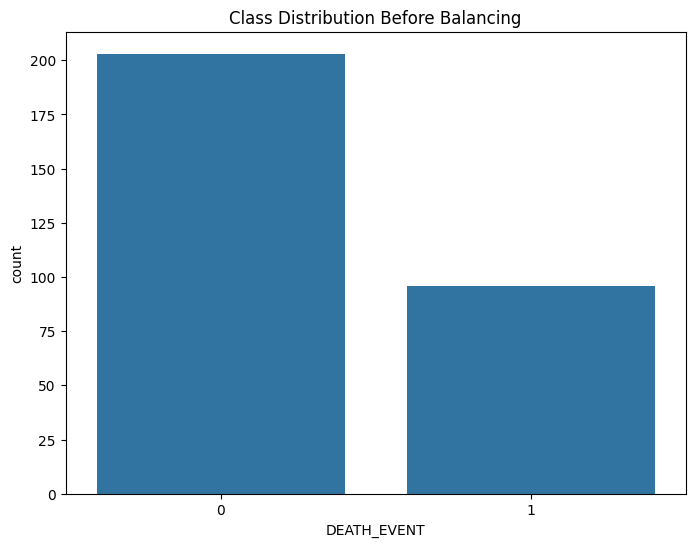

In [17]:
plt.figure(figsize=(8,6))
sns.countplot(x='DEATH_EVENT', data=df)
plt.title('Class Distribution Before Balancing')
plt.show()

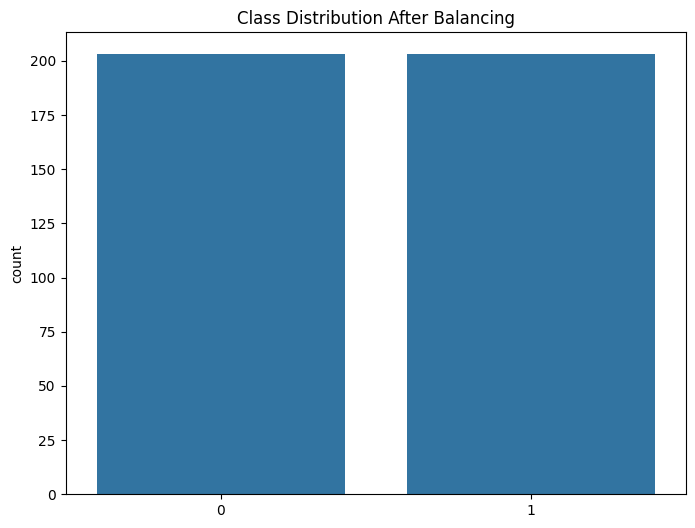

In [18]:
plt.figure(figsize=(8,6))
sns.countplot(x=y_resampled)
plt.title('Class Distribution After Balancing')
plt.show()

In [19]:
# Define parameters
chromosome_length = len(X.columns)
mutation_rate = 0.01
early_stopping_patience = 10  # Adjust as needed
elitism_ratio = 0.1  # Ratio of top individuals to be preserved as elites
elitism = True

In [20]:
# Lists to store results for each combination of max_generations and new_population_size
max_generations_values = [50, 100, 150]
population_sizes = [50, 100, 150, 200, 250, 300]

fitness_results = {}
accuracy_results = {}

In [27]:
def roulette_wheel_selection(population, fitness_values):
    # Convert fitness_values to an array
    fitness_values = np.array(fitness_values)

    # Normalize fitness values to probabilities
    total_fitness = np.sum(fitness_values)
    selection_probs = fitness_values / total_fitness

    # Perform roulette wheel selection to determine parents
    selected_indices = np.random.choice(
        np.arange(len(population)),
        size=len(population),
        p=selection_probs
    )

    # Create the next generation by copying selected parents
    next_generation = population[selected_indices].copy()

    return next_generation


# Define parameters
chromosome_length = len(X.columns)
mutation_rate = 0.01
early_stopping_patience = 10  # Adjust as needed
elitism_ratio = 0.1  # Ratio of top individuals to be preserved as elites

# Dummy data and labels for illustration (you should use your actual data)
dummy_data = X_scaler
dummy_labels = y.values

# Balance the dataset using SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(dummy_data, dummy_labels)

# Lists to store results for each combination of max_generations and new_population_size
max_generations_values = [50, 100, 150]
population_sizes = [50, 100, 150, 200, 250, 300]

fitness_results = {}
accuracy_results = {}

for max_generations in max_generations_values:
    print(f"\nTesting for max_generations: {max_generations}")
    fitness_results[max_generations] = {}
    accuracy_results[max_generations] = {}

    for new_population_size in population_sizes:
        print(f"Testing population size: {new_population_size}")

        # Genetic Algorithm with Elitism
        best_fitness = 0  # Change this to negative infinity if maximizing accuracy
        best_individual = None
        no_improvement_count = 0
        fitness_history = []  # Store fitness values over generations

        # Initial population
        population = np.random.randint(2, size=(X_resampled.shape[0], chromosome_length))

        for generation in range(max_generations):
            # Decode chromosomes, remove unselected features
            selected_features = population * X_resampled
            selected_features = selected_features[:, selected_features.sum(axis=0) > 0]

            # Split the dataset into train and validation sets
            X_train, X_val, y_train, y_val = train_test_split(selected_features, y_resampled, test_size=0.2, random_state=42)

            # Create and train a simple neural network model with TensorFlow
            model = Sequential()
            model.add(Dense(50, activation='relu', input_dim=selected_features.shape[1]))
            model.add(Dense(50, activation='relu'))
            model.add(Dense(1, activation='sigmoid'))
            model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
            model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), verbose=0)

            # Evaluate fitness based on validation accuracy
            accuracy_fitness = model.evaluate(X_val, y_val, verbose=0)[1]
            fitness_values = accuracy_fitness

            # Early stopping check
            if accuracy_fitness > best_fitness:
                best_fitness = accuracy_fitness
                best_individual = population[np.argmax(accuracy_fitness)]
                no_improvement_count = 0
            else:
                no_improvement_count += 1

            # If no improvement for a certain number of generations, stop the algorithm
            if no_improvement_count >= early_stopping_patience:
                print("Early stopping: No improvement for {} generations.".format(early_stopping_patience))
                break

            # Store the fitness value for the current generation
            fitness_history.append(best_fitness)

            # Perform roulette wheel selection to determine parents
            population = roulette_wheel_selection(population, [accuracy_fitness] * len(population))

        # After the loop, use the best_individual for creating the final classifier.
        selected_features = best_individual * X_resampled
        selected_features = selected_features[:, selected_features.sum(axis=0) > 0]

        # Check if at least one feature is selected
        if selected_features.shape[1] > 0:
            # Create and train a simple neural network model with TensorFlow
            final_model = Sequential()
            final_model.add(Dense(50, activation='relu', input_dim=selected_features.shape[1]))
            final_model.add(Dense(50, activation='relu'))
            final_model.add(Dense(1, activation='sigmoid'))
            final_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
            final_model.fit(selected_features, y_resampled, epochs=10, batch_size=32, verbose=0)

            # Evaluate the final model on the same data
            final_accuracy = final_model.evaluate(selected_features, y_resampled, verbose=0)[1]
            print(f"Final Test Accuracy for population size {new_population_size}: {final_accuracy}")
            accuracy_results[max_generations][new_population_size] = final_accuracy
            fitness_results[max_generations][new_population_size] = fitness_history

            # Access the weights of the final model
            final_weights = final_model.get_weights()

            # # Print or analyze the weights as needed
            # for layer_index, layer_weights in enumerate(final_weights):
            #     # print(f"\nLayer {layer_index + 1} weights:")
            #     # print(layer_weights)

        else:
            print("No features selected. Adjust your algorithm parameters or consider using a different feature selection method.")

# Display accuracy results for each combination of max_generations and new_population_size
for max_gen, accuracy_dict in accuracy_results.items():
    for pop_size, final_accuracy in accuracy_dict.items():
        print(f"Final Test Accuracy for Max Gen {max_gen}, Pop Size {pop_size}: {final_accuracy}")



Testing for max_generations: 50
Testing population size: 50
Early stopping: No improvement for 10 generations.
Final Test Accuracy for population size 50: 0.674876868724823
Testing population size: 100
Early stopping: No improvement for 10 generations.
Final Test Accuracy for population size 100: 0.7216748595237732
Testing population size: 150
Early stopping: No improvement for 10 generations.
Final Test Accuracy for population size 150: 0.6945812702178955
Testing population size: 200
Early stopping: No improvement for 10 generations.
Final Test Accuracy for population size 200: 0.7118226885795593
Testing population size: 250
Early stopping: No improvement for 10 generations.
Final Test Accuracy for population size 250: 0.6871921420097351
Testing population size: 300
Early stopping: No improvement for 10 generations.
Final Test Accuracy for population size 300: 0.7241379022598267

Testing for max_generations: 100
Testing population size: 50
Early stopping: No improvement for 10 genera

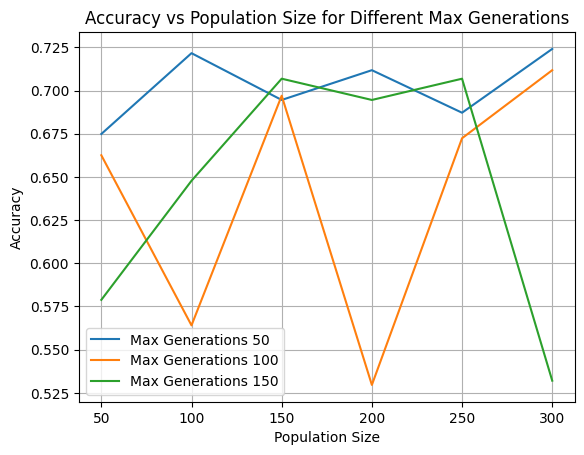

In [28]:
# Plotting accuracy vs population size for each max generation
for max_generations in max_generations_values:
    accuracies = [accuracy_results[max_generations][population_size] for population_size in population_sizes]
    plt.plot(population_sizes, accuracies, label=f"Max Generations {max_generations}")

# Adding labels and legend
plt.xlabel('Population Size')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Population Size for Different Max Generations')
plt.legend()
plt.grid(True)
plt.show()

In [39]:
def roulette_wheel_selection(population, fitness_values):
    # Convert fitness_values to an array
    fitness_values = np.array(fitness_values)

    # Normalize fitness values to probabilities
    total_fitness = np.sum(fitness_values)
    selection_probs = fitness_values / total_fitness

    # Perform roulette wheel selection to determine parents
    selected_indices = np.random.choice(
        np.arange(len(population)),
        size=len(population),
        p=selection_probs
    )

    # Create the next generation by copying selected parents
    next_generation = population[selected_indices].copy()

    return next_generation

# Define parameters
chromosome_length = len(X.columns)
mutation_rate = 0.01
early_stopping_patience = 10  # Adjust as needed
elitism_ratio = 0.1  # Ratio of top individuals to be preserved as elites

# Dummy data and labels for illustration (you should use your actual data)
dummy_data = X_scaler
dummy_labels = y.values

# Balance the dataset using SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(dummy_data, dummy_labels)

# Genetic Algorithm with Elitism
max_generations = 50
new_population_size = 300

best_fitness = 0  # Change this to negative infinity if maximizing accuracy
best_individual = None
no_improvement_count = 0
fitness_history = []  # Store fitness values over generations

# Initial population
population = np.random.randint(2, size=(X_resampled.shape[0], chromosome_length))

for generation in range(max_generations):
    # Decode chromosomes, remove unselected features
    selected_features = population * X_resampled
    selected_features = selected_features[:, selected_features.sum(axis=0) > 0]

    # Split the dataset into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(selected_features, y_resampled, test_size=0.2, random_state=42)

    # Create and train a simple neural network model with TensorFlow
    model = Sequential()
    model.add(Dense(50, activation='relu', input_dim=selected_features.shape[1]))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), verbose=0)

    # Evaluate fitness based on validation accuracy
    accuracy_fitness = model.evaluate(X_val, y_val, verbose=0)[1]
    fitness_values = accuracy_fitness

    # Early stopping check
    if accuracy_fitness > best_fitness:
        best_fitness = accuracy_fitness
        best_individual = population[np.argmax(accuracy_fitness)]
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    # If no improvement for a certain number of generations, stop the algorithm
    if no_improvement_count >= early_stopping_patience:
        print("Early stopping: No improvement for {} generations.".format(early_stopping_patience))
        break

    # Store the fitness value for the current generation
    fitness_history.append(best_fitness)

    # Perform roulette wheel selection to determine parents
    population = roulette_wheel_selection(population, [accuracy_fitness] * len(population))

# After the loop, use the best_individual for creating the final classifier.
selected_features = best_individual * X_resampled
selected_features = selected_features[:, selected_features.sum(axis=0) > 0]

# Check if at least one feature is selected
if selected_features.shape[1] > 0:
    # Create and train a simple neural network model with TensorFlow
    final_model = Sequential()
    final_model.add(Dense(50, activation='relu', input_dim=selected_features.shape[1]))
    final_model.add(Dense(50, activation='relu'))
    final_model.add(Dense(1, activation='sigmoid'))
    final_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    final_model.fit(selected_features, y_resampled, epochs=10, batch_size=32, verbose=0)

    # Evaluate the final model on the same data
    final_accuracy = final_model.evaluate(selected_features, y_resampled, verbose=0)[1]
    print(f"Final Test Accuracy for population size {new_population_size}: {final_accuracy}")

    # Access the weights of the final model
    final_weights = final_model.get_weights()

    # # Print or analyze the weights as needed
    # for layer_index, layer_weights in enumerate(final_weights):
    #     # print(f"\nLayer {layer_index + 1} weights:")
    #     # print(layer_weights)

else:
    print("No features selected. Adjust your algorithm parameters or consider using a different feature selection method.")


Early stopping: No improvement for 10 generations.
Final Test Accuracy for population size 300: 0.9950738916256158


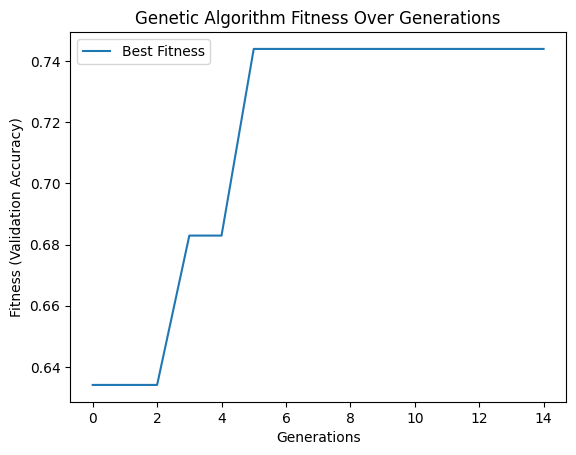

In [32]:
# Plot fitness history
plt.plot(fitness_history, label='Best Fitness')
plt.title("Genetic Algorithm Fitness Over Generations")
plt.xlabel("Generations")
plt.ylabel("Fitness (Validation Accuracy)")
plt.legend()
plt.show()


In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# ... (previous code remains unchanged)

# Lists to store results for each combination of max_generations and new_population_size
max_generations_values = [50, 100, 150]
population_sizes = [50, 100, 150, 200, 250, 300]

fitness_results = {}
accuracy_results = {}

for max_generations in max_generations_values:
    print(f"\nTesting for max_generations: {max_generations}")
    fitness_results[max_generations] = {}
    accuracy_results[max_generations] = {}

    for new_population_size in population_sizes:
        print(f"Testing population size: {new_population_size}")

        # Genetic Algorithm with Elitism
        best_fitness = 0  # Change this to negative infinity if maximizing accuracy
        best_individual = None
        no_improvement_count = 0
        fitness_history = []  # Store fitness values over generations

        # Initial population
        population = np.random.randint(2, size=(X_resampled.shape[0], chromosome_length))

        for generation in range(max_generations):
            # Decode chromosomes, remove unselected features
            selected_features = population * X_resampled
            selected_features = selected_features[:, selected_features.sum(axis=0) > 0]

            # Split the dataset into train and validation sets
            X_train, X_val, y_train, y_val = train_test_split(selected_features, y_resampled, test_size=0.2, random_state=42)

            # Create and train a random forest classifier
            rf_classifier = RandomForestClassifier(n_estimators=50, random_state=42)
            rf_classifier.fit(X_train, y_train)

            # Evaluate fitness based on validation accuracy
            y_val_pred = rf_classifier.predict(X_val)
            accuracy_fitness = accuracy_score(y_val, y_val_pred)
            fitness_values = accuracy_fitness

            # Early stopping check
            if accuracy_fitness > best_fitness:
                best_fitness = accuracy_fitness
                best_individual = population[np.argmax(accuracy_fitness)]
                no_improvement_count = 0
            else:
                no_improvement_count += 1

            # If no improvement for a certain number of generations, stop the algorithm
            if no_improvement_count >= early_stopping_patience:
                print("Early stopping: No improvement for {} generations.".format(early_stopping_patience))
                break

            # Store the fitness value for the current generation
            fitness_history.append(best_fitness)

            # Perform roulette wheel selection to determine parents
            population = roulette_wheel_selection(population, [accuracy_fitness] * len(population))

        # After the loop, use the best_individual for creating the final classifier.
        selected_features = best_individual * X_resampled
        selected_features = selected_features[:, selected_features.sum(axis=0) > 0]

        # Check if at least one feature is selected
        if selected_features.shape[1] > 0:
            # Create and train a random forest classifier
            final_rf_classifier = RandomForestClassifier(n_estimators=50, random_state=42)
            final_rf_classifier.fit(selected_features, y_resampled)

            # Evaluate the final model on the same data
            y_resampled_pred = final_rf_classifier.predict(selected_features)
            final_accuracy = accuracy_score(y_resampled, y_resampled_pred)
            print(f"Final Test Accuracy for population size {new_population_size}: {final_accuracy}")
            accuracy_results[max_generations][new_population_size] = final_accuracy
            fitness_results[max_generations][new_population_size] = fitness_history

            # Access the feature importances of the final model
            feature_importances = final_rf_classifier.feature_importances_

            # # Print or analyze the feature importances as needed
            # print("Feature Importances:")
            # print(feature_importances)

            # # You can also access the individual trees in the forest if needed
            # individual_trees = final_rf_classifier.estimators_
        else:
            print("No features selected. Adjust your algorithm parameters or consider using a different feature selection method.")

# Display accuracy results for each combination of max_generations and new_population_size
for max_gen, accuracy_dict in accuracy_results.items():
    for pop_size, final_accuracy in accuracy_dict.items():
        print(f"Final Test Accuracy for Max Gen {max_gen}, Pop Size {pop_size}: {final_accuracy}")



Testing for max_generations: 50
Testing population size: 50
Early stopping: No improvement for 10 generations.
Final Test Accuracy for population size 50: 0.9876847290640394
Testing population size: 100
Early stopping: No improvement for 10 generations.
Final Test Accuracy for population size 100: 0.9876847290640394
Testing population size: 150
Early stopping: No improvement for 10 generations.
Final Test Accuracy for population size 150: 0.9778325123152709
Testing population size: 200
Early stopping: No improvement for 10 generations.
Final Test Accuracy for population size 200: 1.0
Testing population size: 250
Early stopping: No improvement for 10 generations.
Final Test Accuracy for population size 250: 1.0
Testing population size: 300
Early stopping: No improvement for 10 generations.
Final Test Accuracy for population size 300: 0.9605911330049262

Testing for max_generations: 100
Testing population size: 50
Early stopping: No improvement for 10 generations.
Final Test Accuracy fo

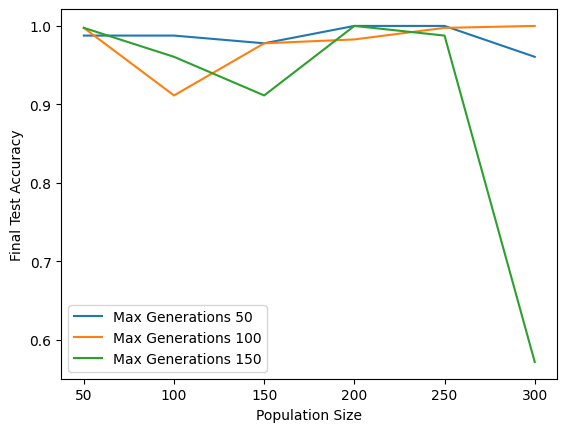

In [41]:
import matplotlib.pyplot as plt

# Plotting accuracy vs population size for each max generation
for max_generations in max_generations_values:
    accuracies = []
    for population_size in population_sizes:
        try:
            final_accuracy = accuracy_results[max_generations][population_size]
            accuracies.append(final_accuracy)
        except KeyError:
            print(f"KeyError: No result for Max Generations {max_generations}, Pop Size {population_size}")

    # Check if accuracies list has the same length as population_sizes
    if len(accuracies) == len(population_sizes):
        plt.plot(population_sizes, accuracies, label=f"Max Generations {max_generations}")
    else:
        print(f"Skipping plotting for Max Generations {max_generations} due to missing data.")

plt.xlabel("Population Size")
plt.ylabel("Final Test Accuracy")
plt.legend()
plt.show()


In [43]:
# Set the desired values
max_generations = 50
new_population_size = 300

# Genetic Algorithm with Elitism
best_fitness = 0  # Change this to negative infinity if maximizing accuracy
best_individual = None
no_improvement_count = 0
fitness_history = []  # Store fitness values over generations

# Initial population
population = np.random.randint(2, size=(X_resampled.shape[0], chromosome_length))

for generation in range(max_generations):
    # Decode chromosomes, remove unselected features
    selected_features = population * X_resampled
    selected_features = selected_features[:, selected_features.sum(axis=0) > 0]

    # Split the dataset into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(selected_features, y_resampled, test_size=0.2, random_state=42)

    # Create and train a random forest classifier
    rf_classifier = RandomForestClassifier(n_estimators=50, random_state=42)
    rf_classifier.fit(X_train, y_train)

    # Evaluate fitness based on validation accuracy
    y_val_pred = rf_classifier.predict(X_val)
    accuracy_fitness = accuracy_score(y_val, y_val_pred)
    fitness_values = accuracy_fitness

    # Early stopping check
    if accuracy_fitness > best_fitness:
        best_fitness = accuracy_fitness
        best_individual = population[np.argmax(accuracy_fitness)]
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    # If no improvement for a certain number of generations, stop the algorithm
    if no_improvement_count >= early_stopping_patience:
        print("Early stopping: No improvement for {} generations.".format(early_stopping_patience))
        break

    # Store the fitness value for the current generation
    fitness_history.append(best_fitness)

    # Perform roulette wheel selection to determine parents
    population = roulette_wheel_selection(population, [accuracy_fitness] * len(population))

# After the loop, use the best_individual for creating the final classifier.
selected_features = best_individual * X_resampled
selected_features = selected_features[:, selected_features.sum(axis=0) > 0]

# Check if at least one feature is selected
if selected_features.shape[1] > 0:
    # Create and train a random forest classifier
    final_rf_classifier = RandomForestClassifier(n_estimators=50, random_state=42)
    final_rf_classifier.fit(selected_features, y_resampled)

    # Evaluate the final model on the same data
    y_resampled_pred = final_rf_classifier.predict(selected_features)
    final_accuracy = accuracy_score(y_resampled, y_resampled_pred)
    print(f"Final Test Accuracy for population size {new_population_size}: {final_accuracy}")
    accuracy_results[max_generations][new_population_size] = final_accuracy
    fitness_results[max_generations][new_population_size] = fitness_history

    # Access the feature importances of the final model
    feature_importances = final_rf_classifier.feature_importances_

    # # Print or analyze the feature importances as needed
    # print("Feature Importances:")
    # print(feature_importances)

    # # You can also access the individual trees in the forest if needed
    # individual_trees = final_rf_classifier.estimators_
else:
    print("No features selected. Adjust your algorithm parameters or consider using a different feature selection method.")


Early stopping: No improvement for 10 generations.
Final Test Accuracy for population size 300: 0.9852216748768473


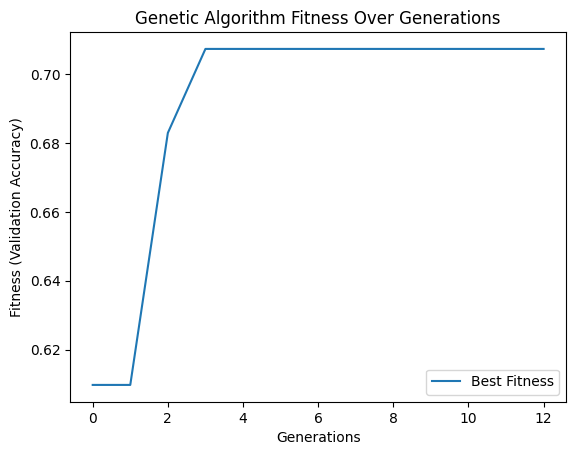

In [44]:
# Plot fitness history
plt.plot(fitness_history, label='Best Fitness')
plt.title("Genetic Algorithm Fitness Over Generations")
plt.xlabel("Generations")
plt.ylabel("Fitness (Validation Accuracy)")
plt.legend()
plt.show()